In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from pathlib import Path
import sys
from gensim import models
import os
import pickle
import csv
import re
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

In [2]:
data = pd.read_csv("BeerDataScienceProject.csv",engine='python')

In [3]:
data.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_palette', 'review_overall', 'review_taste',
       'review_profileName', 'review_aroma', 'review_text', 'review_time'],
      dtype='object')

In [4]:
data.head(3)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604


In [5]:
#beer_ABV - Alcohol by volume (abbreviated as ABV, abv, or alc/vol) is a standard measure of how much alcohol (ethanol) is contained in a given volume of an alcoholic beverage (expressed as a volume percent).

In [6]:
data.dtypes

beer_ABV              float64
beer_beerId             int64
beer_brewerId           int64
beer_name              object
beer_style             object
review_appearance     float64
review_palette        float64
review_overall        float64
review_taste          float64
review_profileName     object
review_aroma          float64
review_text            object
review_time             int64
dtype: object

In [7]:
#data['review_time'] = pd.to_datetime(data['review_time'])
#converting the 'review_time' from UNIX timestap to date_time format

data['review_time'] = data['review_time'].apply(lambda x :datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['year'] = data['review_time'].apply(lambda x : x.split('-')[0])#.astype(int)

In [8]:
data.head(3)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-17 02:27:03,2009
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01 19:14:57,2009
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",2009-03-01 19:40:04,2009


In [9]:
data.shape

(528870, 14)

In [10]:
# Handling the NULL values - columns - review_profileName, review_text, beer_ABV

In [11]:
data.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
year                      0
dtype: int64

In [12]:
(data.isna().sum()/len(data)) * 100

beer_ABV              3.834591
beer_beerId           0.000000
beer_brewerId         0.000000
beer_name             0.000000
beer_style            0.000000
review_appearance     0.000000
review_palette        0.000000
review_overall        0.000000
review_taste          0.000000
review_profileName    0.021744
review_aroma          0.000000
review_text           0.022501
review_time           0.000000
year                  0.000000
dtype: float64

In [13]:
#NULL - column - review_profileName  

In [14]:
data['review_profileName'].describe()

count             528755
unique             22800
top       northyorksammy
freq                1858
Name: review_profileName, dtype: object

In [15]:
data['review_profileName'].mode()

0    northyorksammy
dtype: object

In [16]:
data.loc[data['review_profileName'].isna(),'review_profileName'] = data['review_profileName'].fillna(data['review_profileName'].mode()[0])

In [17]:
data.isnull().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName        0
review_aroma              0
review_text             119
review_time               0
year                      0
dtype: int64

In [18]:
#NULL - column - review_text  

In [19]:
data['review_text'].describe()

count     528751
unique    528371
top       #NAME?
freq          92
Name: review_text, dtype: object

In [20]:
data['review_text'].mode()

0    #NAME?
dtype: object

In [21]:
data.loc[data['review_text'].isna(),'review_text'] = data['review_text'].fillna(data['review_text'].mode()[0])

In [22]:
len(data['review_text'].unique())

528371

In [23]:
data['review_text'].fillna(data['review_text'].mode()[0],inplace = True)

In [24]:
data.isnull().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName        0
review_aroma              0
review_text               0
review_time               0
year                      0
dtype: int64

In [25]:
data['review_text'].describe()

count     528870
unique    528371
top       #NAME?
freq         211
Name: review_text, dtype: object

In [26]:
#NULL - column - beer_ABV  

In [27]:
data['beer_ABV'].describe()

count    508590.000000
mean          7.017442
std           2.204460
min           0.010000
25%           5.300000
50%           6.500000
75%           8.500000
max          57.700000
Name: beer_ABV, dtype: float64

In [28]:
data['beer_ABV'].value_counts()

5.00     38935
5.50     22213
9.00     21319
8.00     20831
6.00     20725
6.50     17028
7.00     16496
10.00    14087
7.50     13992
9.50     13739
4.90     12806
5.80     12575
5.40     11661
5.30     11365
5.60     10558
5.20     10373
6.20     10315
4.80     10062
8.50      9705
7.20      8736
4.50      8097
6.80      7953
5.90      7825
9.20      7693
11.00     7525
10.50     7508
4.70      6976
6.70      6590
4.00      5349
5.10      5259
         ...  
6.33         2
6.32         2
6.45         2
0.30         2
3.95         2
5.36         2
1.00         2
43.00        2
0.90         2
7.26         2
12.80        2
13.30        1
1.40         1
7.13         1
6.71         1
16.10        1
5.53         1
5.19         1
8.41         1
10.17        1
7.17         1
4.45         1
5.87         1
2.75         1
4.46         1
19.20        1
30.86        1
6.95         1
5.47         1
57.70        1
Name: beer_ABV, Length: 283, dtype: int64

In [29]:
data[['beer_name','beer_ABV']][data.beer_ABV.isna() == True]#.unique()

,beer_name,beer_ABV
267,Cauldron Espresso Stout,NaN
718,Alpha Beta,NaN
781,Imperial Stout,NaN
910,Megalodon,NaN
926,Holiday Trappist Style Ale,NaN
941,Emerald Ale,NaN
942,Emerald Ale,NaN
943,Emerald Ale,NaN
949,City Razz,NaN
950,City Light,NaN


In [30]:
len(data['beer_name'].unique())

18339

In [31]:
len(data['beer_ABV'].unique())

284

In [32]:
print('Unique values of beer_name :',data.beer_name.nunique(dropna=False))
print('Unique values of beer_ABV :',data.beer_ABV.nunique(dropna=False))

Unique values of beer_name : 18339
Unique values of beer_ABV : 284


In [33]:
#create a dataframe for beer_ABV not null data
data_notnull = data.loc[data.beer_ABV.notna(),['beer_name','beer_ABV']].sort_values(by = 'beer_name', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data_notnull.head()

,beer_name,beer_ABV
432191,"""100"" Pale Ale",6.6
327824,"""33"" Export",4.8
327823,"""33"" Export",4.8
327825,"""33"" Export",4.8
322080,"""76"" Anniversary Ale",7.6


In [34]:
print('Unique values of beer_name - Not NULL :',data_notnull.beer_name.nunique(dropna=False))
print('Unique values of beer_ABV - Not NULL :',data_notnull.beer_ABV.nunique(dropna=False))

Unique values of beer_name - Not NULL : 14028
Unique values of beer_ABV - Not NULL : 283


In [35]:
get_items = lambda vals : max(Counter(vals).items(), key = lambda x : x[1])[0] 
beer_name_beer_ABV = data_notnull.groupby('beer_name')['beer_ABV'].agg(get_items).to_dict()
beer_name_beer_ABV

{'"100" Pale Ale': 6.6,
 '"33" Export': 4.8,
 '"76" Anniversary Ale': 7.6,
 '"76" Anniversary Ale With English Hops': 7.6,
 '"Fade To Black" Porter': 5.6,
 '"Great Satchmo" Stout': 4.5,
 '"Jessica & Brendan\'s" Bridal Ale': 5.0,
 '"Just One More" Scotch Ale': 10.5,
 '"Nein Toll Bier" German Alt': 5.4,
 '"O Smokey Night"': 7.2,
 '"Old Yeltsin" Imperial Stout': 9.0,
 '"Requisite" Imperialistic Stout': 9.0,
 '"Stout Stoat" Stout': 4.5,
 '"The Buk" Pale Ale': 5.5,
 '"The Wind Cried Mari..." Scottish Heather Ale': 4.4,
 '"Woosta" Weizenbock': 8.2,
 '&#268;erné Zámecké': 4.2,
 '&#960;&#964;&#953;&#963;&#940;&#957;&#951; (tisane)': 2.0,
 "'Pooya Porter": 5.5,
 "'Vagabond Blonde' Blonde Ale": 5.5,
 "'t Gaverhopke / Tired Hands Bitter Sweet Symphony": 7.8,
 "'t Gaverhopke De Kriek (Red Cap)": 7.0,
 "'t Gaverhopke Den Blond 8° (White Cap)": 8.0,
 "'t Gaverhopke Den Bruin 8° (Blue Cap)": 8.0,
 "'t Gaverhopke Extra": 12.0,
 "'t Gaverhopke Zingende Blondine": 9.8,
 "'t Goeye Goet Dubbel": 7.0,
 "'t

In [36]:
data.beer_ABV = data.beer_name.map(beer_name_beer_ABV)

In [37]:
data.loc[data.beer_ABV.isna()].shape[0]

17920

In [38]:
data.loc[data.beer_ABV.notna(),['beer_name','beer_ABV']]

,beer_name,beer_ABV
0,Sausa Weizen,5.0
1,Red Moon,6.2
2,Black Horse Black Beer,6.5
3,Sausa Pils,5.0
4,Cauldron DIPA,7.7
5,Caldera Ginger Beer,4.7
6,Caldera Ginger Beer,4.7
7,Caldera Ginger Beer,4.7
8,Caldera Ginger Beer,4.7
9,Caldera Ginger Beer,4.7


In [39]:
get_items1 = lambda vals : max(Counter(vals).items(), key = lambda x :(x[0] != np.NaN) & x[1])[0] 
beer_name_abv2 = data.groupby('beer_name')['beer_ABV'].agg(get_items1).to_dict()
beer_name_abv2

{'"100" Pale Ale': 6.6,
 '"33" Export': 4.8,
 '"76" Anniversary Ale': 7.6,
 '"76" Anniversary Ale With English Hops': 7.6,
 '"Fade To Black" Porter': 5.6,
 '"Great Satchmo" Stout': 4.5,
 '"Jessica & Brendan\'s" Bridal Ale': 5.0,
 '"Just One More" Scotch Ale': 10.5,
 '"Nein Toll Bier" German Alt': 5.4,
 '"O Smokey Night"': 7.2,
 '"Old Yeltsin" Imperial Stout': 9.0,
 '"Requisite" Imperialistic Stout': 9.0,
 '"Stout Stoat" Stout': 4.5,
 '"Talk To Me" IPA': nan,
 '"The Bridge" Nut-Brown Ale': nan,
 '"The Buk" Pale Ale': 5.5,
 '"The Mountain" Ale': nan,
 '"The Wind Cried Mari..." Scottish Heather Ale': 4.4,
 '"Woosta" Weizenbock': 8.2,
 '&#268;erné Zámecké': 4.2,
 '&#960;&#964;&#953;&#963;&#940;&#957;&#951; (tisane)': 2.0,
 "'99 Wee Heavy Scotch Ale": nan,
 "'Bout Time Barley Wine": nan,
 "'Pooya Porter": 5.5,
 "'Sconnie Pale Ale": nan,
 "'Sconnie Rustic Trail Amber": nan,
 "'Sconnie Tall Blonde Ale": nan,
 "'Tis The Seasonator": nan,
 "'Vagabond Blonde' Blonde Ale": 5.5,
 "'Zula Stout": na

In [40]:
#replace the beer_ABV feture with the mode of the 'beer_ABV' feature corresponding to the beer_name

data.beer_ABV = data.beer_name.map(beer_name_abv2)

In [41]:
data.shape[0]

528870

In [42]:
data_temp = data.loc[data.beer_ABV.isna(),['beer_name','beer_ABV']]
data_temp.groupby('beer_name')['beer_ABV'].count().to_dict()

{'"Talk To Me" IPA': 0,
 '"The Bridge" Nut-Brown Ale': 0,
 '"The Mountain" Ale': 0,
 "'99 Wee Heavy Scotch Ale": 0,
 "'Bout Time Barley Wine": 0,
 "'Sconnie Pale Ale": 0,
 "'Sconnie Rustic Trail Amber": 0,
 "'Sconnie Tall Blonde Ale": 0,
 "'Tis The Seasonator": 0,
 "'Zula Stout": 0,
 '1,000th Batch Strong IPA': 0,
 '100% Brett IPA': 0,
 '10th Anniversary Ale': 0,
 '11th Anniversary Double IPA': 0,
 '13 Hour Wheat Wine': 0,
 '14 Year Anniversary Ale': 0,
 '150th Anniversary Ale': 0,
 '150th Anniversary All Malt Lager': 0,
 '150th Anniversary Beer': 0,
 '152 Pilsner': 0,
 '15th Anniversary': 0,
 '1602 Colonial Style Porter': 0,
 '17 Year Anniversary Ale': 0,
 '18 Barrel IPA': 0,
 '1803 Fat Ox Ale': 0,
 '1849 Irish Red Ale': 0,
 '1860 IPA': 0,
 '1972': 0,
 '1997 Saison': 0,
 '19th Hole Ale': 0,
 '20 Year Amber Ale': 0,
 '20th Street Green Hop Ale': 0,
 '20th Street Pale Ale - Citra': 0,
 '21 Bones Salute ESB': 0,
 '25 Belgian Dubbel Style Anniversary Ale': 0,
 '2x4 Ale': 0,
 '3 Cordillera

In [43]:
#beer_ABV values are not present at for some records, we will drop these records

In [44]:
data.dropna(inplace=True)
data

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-17 02:27:03,2009
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01 19:14:57,2009
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",2009-03-01 19:40:04,2009
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",2009-02-16 00:42:25,2009
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",2010-12-31 00:23:26,2010
5,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,3.5,3.0,3.0,oline73,3.5,Poured from the bottle into a Chimay goblet. A...,2012-01-02 22:47:39,2012
6,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,3.5,3.5,4.0,Reidrover,4.0,"22 oz bottle from ""Lifesource"" Salem. $3.95 Ni...",2011-10-19 07:55:15,2011
7,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,2.5,3.0,2.0,alpinebryant,3.5,"Bottle says ""Malt beverage brewed with Ginger ...",2011-05-25 03:56:58,2011
8,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,3.0,4.0,3.5,LordAdmNelson,4.0,I'm not sure why I picked this up... I like gi...,2010-11-23 01:05:03,2010
9,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,5.0,3.5,4.5,4.0,augustgarage,4.0,Poured from a 22oz bomber into my Drie Fontein...,2010-09-28 05:45:24,2010


In [45]:
data.isna().sum()

beer_ABV              0
beer_beerId           0
beer_brewerId         0
beer_name             0
beer_style            0
review_appearance     0
review_palette        0
review_overall        0
review_taste          0
review_profileName    0
review_aroma          0
review_text           0
review_time           0
year                  0
dtype: int64

# Questions

### 1.Rank top 3 Breweries which produce the strongest beers?

In [46]:
#brewerId is given brewername is not there in the data so we will consider only beer_brewerId

In [47]:
data.beer_brewerId.value_counts().head()

35      38814
140     28656
132     23450
1199    19955
3818    15858
Name: beer_brewerId, dtype: int64

In [48]:
#beer_ABV - how much alcohol (ethanol) is contained
data_q1 = data[['beer_brewerId','beer_ABV']]
print("top 3 Breweries which produce the strongest beers")
data_q1.groupby('beer_brewerId').mean().sort_values(['beer_ABV'],ascending = False).head(3)

top 3 Breweries which produce the strongest beers


,beer_ABV
beer_brewerId,
6513,19.228824
736,13.750000
24215,12.466667


#### Answer Q1
Top 3 Breweries
beer_brewerId > 6513, 736, and 24215

### 2.Which year did beers enjoy the highest ratings? 

In [49]:
data.head(1)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-17 02:27:03,2009


In [50]:
data.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-17 02:27:03,2009
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01 19:14:57,2009
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",2009-03-01 19:40:04,2009
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",2009-02-16 00:42:25,2009
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",2010-12-31 00:23:26,2010


In [51]:
data_q2 = data[['year','review_overall']]

In [52]:
data_q2.groupby('year').mean().sort_values(['review_overall'],ascending = False).head(1)

,review_overall
year,
2000,4.233333


In [53]:
#plot
data_q2 =  data_q2.groupby('year').mean().sort_values(['review_overall'],ascending = False).reset_index()

In [54]:
data_q2.head(1)

,year,review_overall
0,2000,4.233333


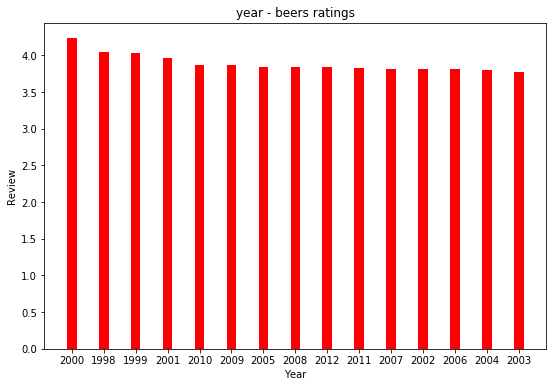

In [55]:
figure(figsize=(9, 6)) 
plt.bar(data_q2['year'], data_q2['review_overall'], color ='red',
        width = 0.3)

plt.xlabel("Year")
plt.ylabel("Review")
plt.title("year - beers ratings")

plt.show()

#### Answer Q2
Year -> 2000

### 3. Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?**

In [56]:
data_q3 = data[['review_taste','review_aroma','review_appearance', 'review_palette','review_overall']]

In [57]:
data_q3_corr = data_q3.corr()
data_q3_corr

,review_taste,review_aroma,review_appearance,review_palette,review_overall
review_taste,1.000000,0.723056,0.551939,0.601100,0.689629
review_aroma,0.723056,1.000000,0.531321,0.703602,0.780588
review_appearance,0.551939,0.531321,1.000000,0.544819,0.483247
review_palette,0.601100,0.703602,0.544819,1.000000,0.598400
review_overall,0.689629,0.780588,0.483247,0.598400,1.000000


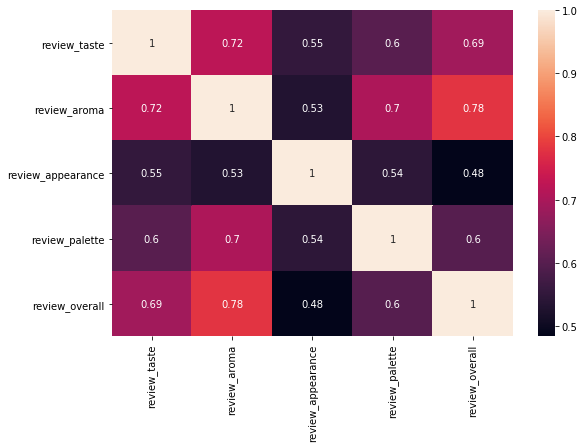

In [58]:
#plt.figure(figsize=(10,6))
figure(figsize=(9, 6)) 
sns.heatmap(data=data_q3_corr, annot=True)#,cmap="YlGnBu")

#### Answer Q3
The review_aroma feature is more correlated with the review_overall feature. So, **review_aroma** is an important

### 4.If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

In [59]:
 #To recommend good beer to the freinds, We will check review_overall and beer_ABV with beer_name

In [60]:
data_q4 = data[['beer_name','review_overall','beer_ABV']]

In [61]:
data_q4 = data_q4.groupby('beer_name').mean().sort_values(['review_overall','beer_ABV'],ascending = False).reset_index().head(3)
data_q4

,beer_name,review_overall,beer_ABV
0,AleSmith Speedway Stout - Oak Aged,5.0,12.0
1,Pilot Series Imperial Sweet Stout - Palm Ridge...,5.0,12.0
2,Bees Knees Barleywine,5.0,11.2


#### Answer Q4
3 Beers to recommend -> AleSmith Speedway Stout - Oak Aged, 
                        Pilot Series Imperial Sweet Stout - Palm Ridge Reserve Barrel Aged,
                        Bees Knees Barleywine

### 5.Which Beer style seems to be the favorite based on reviews written by users?

In [62]:
sent = SentimentIntensityAnalyzer()
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in data['review_text']]
data['review_text_sentiment_score'] = polarity
data.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,review_text_sentiment_score
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-17 02:27:03,2009,0.13
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01 19:14:57,2009,0.59
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",2009-03-01 19:40:04,2009,0.30
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",2009-02-16 00:42:25,2009,0.98
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",2010-12-31 00:23:26,2010,0.95


In [63]:
data_q5 = data[['beer_style','review_text','review_text_sentiment_score']]
data_q5 = data_q5[data_q5.review_text != '#NAME?']
data_q5 = data_q5.groupby(['beer_style']).sum().sort_values(['review_text_sentiment_score'],ascending = False).reset_index()
data_q5.head(1)

,beer_style,review_text_sentiment_score
0,American IPA,32767.87


#### Answer Q5
beer_style -> American IPA

### 6.How does written review compare to overall review score for the beer styles?

In [64]:
data_q6 = data[['beer_style','review_overall','review_text','review_text_sentiment_score']]
data_q6 = data_q6[data_q6.review_text != '#NAME?']
data_q6_both = data_q6.groupby(['beer_style']).sum().sort_values(['review_text_sentiment_score','review_overall'],ascending = False).reset_index()
data_q6_both.head(3)

,beer_style,review_overall,review_text_sentiment_score
0,American IPA,168693.5,32767.87
1,American Double / Imperial IPA,102035.5,20299.90
2,American Double / Imperial Stout,95163.0,19659.88


In [65]:
#Compare 1
data_q6_review_text_sentiment_score = data_q6[['beer_style','review_text_sentiment_score']]
data_q6_review_text_sentiment_score = data_q6_review_text_sentiment_score.groupby(['beer_style']).sum().sort_values(['review_text_sentiment_score'],ascending = False).reset_index()
data_q6_review_text_sentiment_score.head(12)

,beer_style,review_text_sentiment_score
0,American IPA,32767.87
1,American Double / Imperial IPA,20299.90
2,American Double / Imperial Stout,19659.88
3,American Pale Ale (APA),14187.06
4,Russian Imperial Stout,13760.83
5,American Amber / Red Ale,13657.84
6,Belgian Strong Dark Ale,12760.23
7,American Porter,11734.11
8,Fruit / Vegetable Beer,11101.83
9,Witbier,9719.87


In [66]:
##Compare 2
data_q6_review_overall = data_q6[['beer_style','review_overall']]
data_q6_review_overall = data_q6_review_overall.groupby(['beer_style']).sum().sort_values(['review_overall'],ascending = False).reset_index()
data_q6_review_overall.head(12)

,beer_style,review_overall
0,American IPA,168693.5
1,American Double / Imperial IPA,102035.5
2,American Double / Imperial Stout,95163.0
3,American Pale Ale (APA),74033.5
4,American Amber / Red Ale,68765.5
5,Russian Imperial Stout,68421.5
6,Belgian Strong Dark Ale,61423.5
7,American Porter,60657.5
8,Fruit / Vegetable Beer,52424.5
9,Witbier,50047.5


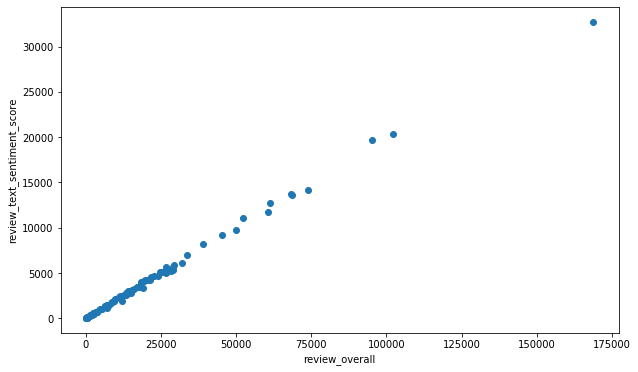

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = data_q6_both['review_overall'], y = data_q6_both['review_text_sentiment_score'])
plt.xlabel("review_overall")
plt.ylabel("review_text_sentiment_score")

plt.show()

#### Answer Q6
written review and overall review - both are aligned

### 7.How do find similar beer drinkers by using written reviews only?**  

In [68]:
#DOC2VEC 

In [69]:
data.insert(loc=0, column='row_num', value=np.arange(len(data)))

In [70]:
data.head()

,row_num,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,review_text_sentiment_score
0,0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-17 02:27:03,2009,0.13
1,1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01 19:14:57,2009,0.59
2,2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",2009-03-01 19:40:04,2009,0.30
3,3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",2009-02-16 00:42:25,2009,0.98
4,4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",2010-12-31 00:23:26,2010,0.95


In [71]:
def removespecialcharacters(str1):
    # Special Characters
    review_text = re.sub(r"[^A-Za-z0-9,!.?']", " ", str1)
    return review_text

def removestopwords(str):
    # return str
    filtered_sentence = []
    word_tokens = word_tokenize(str)
    for x in word_tokens:
        if x not in stop_words:
            filtered_sentence.append(x)
    return " ".join(filtered_sentence)

In [72]:
homepath = str(Path.home())
modelPath = os.path.join(homepath,"models")

if not os.path.exists(modelPath):
    os.makedirs(modelPath)
print("modelPath",modelPath)

homepath = str(Path.home())

#Note We have commented the code part of the cleaning process
#In cleaning process we should remove special characters, stopwords, and common words which is not helpful in our analysis.
#We wont be doing lemmatization or stemming for Doc2Vec model

data_q7 = data[['review_text','row_num']]
data_q7 = data_q7.reset_index()
#for i in range(len(data_q7)):
#    data_q7['review_text'].iloc[i] = removespecialcharacters(data_q7['review_text'].iloc[i])
#    data_q7['review_text'].iloc[i] = removestopwords(data_q7['review_text'].iloc[i])

modelPath C:\Users\Kuldeep\models


In [73]:
documents = [TaggedDocument(words=data_q7["review_text"].iloc[i].split(), tags=[(data_q7.loc[i,"row_num"])]) for i in range(len(data_q7)) if isinstance(data_q7["review_text"][i], float) == False]

In [74]:
model = Doc2Vec(vector_size=50, min_count=2, epochs=1)  #not tuned
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
model.save(os.path.join(modelPath,"DOC2VEC.model"))

In [95]:
rownum = int(input("Enter row number (record) to get get the details of similar drinkers "))

Enter row number (record) to get get the details of similar drinkers 6


In [96]:
data[data['row_num'] == rownum]

,row_num,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,review_text_sentiment_score
6,6,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,3.5,3.5,4.0,Reidrover,4.0,"22 oz bottle from ""Lifesource"" Salem. $3.95 Ni...",2011-10-19 07:55:15,2011,0.97


In [97]:
get_review_text = data['review_text'][data['row_num'] == rownum ]
get_review_text = get_review_text.reset_index()
get_review_text = get_review_text['review_text'][0]

In [98]:
model = Doc2Vec.load(os.path.join(modelPath,"DOC2VEC.model"))
test_words = get_review_text.split()
inferred_vector = model.infer_vector(test_words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

C:\Users\Kuldeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  after removing the cwd from sys.path.


In [99]:
row_nums = [sims[i][0] for i in range(len(sims)) if sims[i][1] > 0.60 and sims[i][0] != rownum ] #  cut off > 60% match
row_nums

[20067]

In [100]:
# Similar beer drinkers
data[data['row_num'].isin(row_nums)]

,row_num,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,review_text_sentiment_score
21203,20067,6.5,20478,1199,Founders Harvest Ale,American IPA,3.0,4.5,3.5,3.5,beermanbrian,3.5,Golden color with lots of floaters. Minimal he...,2007-12-12 07:14:11,2007,0.83


#### Answer 7
To get the similar beer drinkers, Specify the record by entering row_num for which you want to get similar beer drinkers. It will fetch all the records of similar beer drinkers which are matching greater than 60%. 